In [2]:
from bs4 import BeautifulSoup
import requests
from IPython.display import display, Image
import tempfile
import os

All Servers Date
Event period: November 21st, 2024 - December 4th, 2024
Total item (entries) in shop: 25
Item: 'Momo Belia Deviluke'
Stock: '5'
Price: '8000'


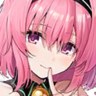

--
All Servers Date
Event period: September 15th, 2022 - October 5th, 2022
Total item (entries) in shop: 27
Item: 'Wakatsuki'
Stock: '5'
Price: '8000'


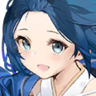

--


True

In [11]:
### TODO: scrape every event shop.
###       only get the ones with a vaible shop (debug search for keyword item shop to check for compatability)
###       Put bad entries in a list txt file and skip in the future.
###       Serverless function? Python (reality: just rewrite in js)
# https://azurlane.koumakan.jp/wiki/Events#Limited_Event_List

def al_scraper(url, show=True):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the EN Servers row and extract dates
    event_table = soup.find('table', class_='event-infobox')
    if event_table:
        rows = event_table.find_all('tr')
        for i, row in enumerate(rows):
            th = row.find('th')
            if th and 'en server' in th.text.lower():
                if i + 2 < len(rows):
                    start_date = rows[i+1].find_all('td')[1].text.strip()
                    end_date = rows[i+2].find_all('td')[1].text.strip()
                    if show:
                        print("EN Servers Date")
                        print(f"Event period: {start_date} - {end_date}")
            elif th and 'all server' in th.text.lower():
                if i + 2 < len(rows):
                    start_date = rows[i+1].find_all('td')[1].text.strip()
                    end_date = rows[i+2].find_all('td')[1].text.strip()
                    if show:
                        print("All Servers Date")
                        print(f"Event period: {start_date} - {end_date}")

    # Find all shop items
    shop_items = soup.find_all('div', class_='item-frame')
    
    # Extract and print details for each item
    # Get total number of shop items
    total_items = len(shop_items)

    if not shop_items or total_items <= 0:
        return False

    if show:
        print(f"Total item (entries) in shop: {total_items}")
    for item in shop_items:
        stock = item.find('div', class_='item-stock').text.strip().replace('Available:', '').strip()
        name = item.find('div', class_='item-name').text.strip()
        price = item.find('div', class_='item-price').text.strip()
        if show: 
            print(f"Item: '{name}'")
            print(f"Stock: '{stock}'")
            print(f"Price: '{price}'")
        image_url = item.find('div', class_='item-image-frame').find('img')['src']
        if not image_url.startswith('http'):
            image_url = 'https://azurlane.koumakan.jp' + image_url
        # print(f"Image URL: {image_url}")

        if show:
            img = download_image(image_url, name)
            display(Image(img))
            print("--")
        
        return True
    
def download_image(url, name):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, f"{name}.jpg")
    with open(temp_path, 'wb') as f:
        f.write(requests.get(url).content)
    return temp_path
    
def picsum_demo():
    temp_dir = tempfile.gettempdir()
    # Download a random image from Lorem Picsum as comparison
    lorem_url = "https://picsum.photos/200/300"
    lorem_path = os.path.join(temp_dir, "lorem_comparison.jpg")
    with open(lorem_path, 'wb') as f:
        f.write(requests.get(lorem_url).content)
    print(f"Lorem Picsum comparison saved to: {lorem_path}")
    display(Image(lorem_path))

al_scraper(url = 'https://azurlane.koumakan.jp/wiki/Dangerous_Inventions_Incoming!')
al_scraper(url = 'https://azurlane.koumakan.jp/wiki/Violet_Tempest,_Blooming_Lycoris')
al_scraper(url = 'https://azurlane.koumakan.jp/wiki/Visitors_Dyed_in_Red_Rerun')

In [3]:
# Get all event URLs from the events page
event_list_url = 'https://azurlane.koumakan.jp/wiki/Events#Limited_Event_List'
response = requests.get(event_list_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the Limited Event List section and get all table headers with links
event_table = soup.find('span', {'id': 'Limited_Event_List'}).find_parent('h2').find_next('table')
event_links = event_table.find_all('th')

# Open a file to store events without shops
# Create output directory if it doesn't exist
if not os.path.exists('out'):
    os.makedirs('out')

shopless_events = open('out/shopless_event_urls.txt', 'a+')
shop_events = open('out/shop_event_urls.txt', 'a+')

# Read existing URLs and remove duplicates
existing_urls = set(shopless_events.readlines())
shopless_events.seek(0)
shopless_events.truncate()
shopless_events.writelines(sorted(set(existing_urls)))


from concurrent.futures import ThreadPoolExecutor

def process_event(link):
    if link and link.get('href'):
        event_url = 'https://azurlane.koumakan.jp' + link['href']
        if event_url in existing_urls:
            return
        print(f"Event URL: {event_url}")
        ret = al_scraper(event_url, show=False)
        if not ret:
            # print("\tNo items found in shop.")
            shopless_events.write(event_url + '\n')
        else:
            shop_events.write(event_url + '\n')
with ThreadPoolExecutor(max_workers=5) as executor:
    for header in event_links:
        a_links = header.find_all('a')
        executor.map(process_event, a_links)



Event URL: https://azurlane.koumakan.jp/wiki/Strive,_Wish_and_StrategizeEvent URL: https://azurlane.koumakan.jp/wiki/Opposite-Colored

Event URL: https://azurlane.koumakan.jp/wiki/Divergent_Chessboard
Event URL: https://azurlane.koumakan.jp/wiki/Tanabata
Event URL: https://azurlane.koumakan.jp/wiki/Lead_Color_Remembrance
Event URL: https://azurlane.koumakan.jp/wiki/Visitors_Dyed_in_Red
Event URL: https://azurlane.koumakan.jp/wiki/Glorious_Battle
Event URL: https://azurlane.koumakan.jp/wiki/Halloween#Night_of_the_"Witches"
Event URL: https://azurlane.koumakan.jp/wiki/Popularity_Contest
Shop found
Event URL: https://azurlane.koumakan.jp/wiki/Tea_Time
Event URL: https://azurlane.koumakan.jp/wiki/Niconico_Collaboration#Year_36_Class_Z_Teacher_Z23
Event URL: https://azurlane.koumakan.jp/wiki/The_Return_of_the_War_God
Event URL: https://azurlane.koumakan.jp/wiki/Christmas_2017
Event URL: https://azurlane.koumakan.jp/wiki/Fallen_Wings
Event URL: https://azurlane.koumakan.jp/wiki/Happy_New_Yea

Processing https://azurlane.koumakan.jp/wiki/Divergent_Chessboard
Total item (entries) in shop: 14
Item: 'Tirpitz'
Stock: '1'
Price: '8000'


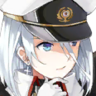

--
Processing https://azurlane.koumakan.jp/wiki/Visitors_Dyed_in_Red_Rerun
Total item (entries) in shop: 11
Item: 'Zuikaku'
Stock: '1'
Price: '8000'


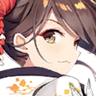

--
Processing https://azurlane.koumakan.jp/wiki/Opposite-Colored_Rerun
EN Servers Date
Event period: October 31st, 2019 - November 13th, 2019
Total item (entries) in shop: 17
Item: 'Tirpitz'
Stock: '1'
Price: '8000'


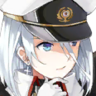

--
Processing https://azurlane.koumakan.jp/wiki/Ink-Stained_Steel_Sakura
EN Servers Date
Event period: April 11th, 2019 - April 25th, 2019
Total item (entries) in shop: 27
Item: 'Haruna'
Stock: '1'
Price: '4000'


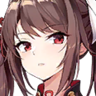

--
Processing https://azurlane.koumakan.jp/wiki/Iris_of_Light_and_Dark
EN Servers Date
Event period: June 27th, 2019 - July 10th, 2019
Total item (entries) in shop: 18
Item: 'Le Triomphant'
Stock: '1'
Price: '8000'


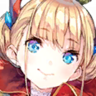

--
Processing https://azurlane.koumakan.jp/wiki/Crimson_Echoes
EN Servers Date
Event period: January 10th, 2019 - January 31st, 2019
Total item (entries) in shop: 43
Item: 'Kaga'
Stock: '1'
Price: '8000'


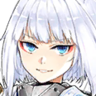

--
Processing https://azurlane.koumakan.jp/wiki/Hibiscus-scented_Idol
EN Servers Date
Event period: March 28th, 2019 - April 17th, 2019
All Servers Date
Event period: March 19th, 2020 - April 8th, 2020
Total item (entries) in shop: 27
Item: 'Hibiscus-scented Idol'
Stock: '1'
Price: '300'


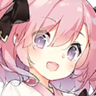

--
Processing https://azurlane.koumakan.jp/wiki/Ink-Stained_Steel_Sakura_Rerun
EN Servers Date
Event period: July 16th, 2020 - July 29th, 2020
Total item (entries) in shop: 14
Item: 'Haruna'
Stock: '1'
Price: '4000'


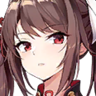

--
Processing https://azurlane.koumakan.jp/wiki/Scherzo_of_Iron_and_Blood
All Servers Date
Event period: May 23rd, 2019 - June 12th, 2019
Total item (entries) in shop: 20
Item: 'King George VOriginal Run'
Stock: '1'
Price: '8000'


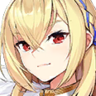

--
Processing https://azurlane.koumakan.jp/wiki/Scherzo_of_Iron_and_Blood#Science_Rules.21
All Servers Date
Event period: May 23rd, 2019 - June 12th, 2019
Total item (entries) in shop: 20
Item: 'King George VOriginal Run'
Stock: '1'
Price: '8000'


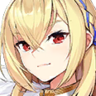

--


In [12]:
# Read shop event URLs and scrape each one
with open('out/shop_event_urls.txt', 'r') as f:
    shop_urls = f.readlines()

# Clean URLs by removing whitespace/newlines
shop_urls_clean = [url.strip() for url in shop_urls]

# # use exceptions to debug
# for url, clean_url in zip(shop_urls, shop_urls_clean):
#     if url != clean_url:
#         raise ValueError(f"URL mismatch after cleaning:\nOriginal: {url!r}\nCleaned: {clean_url!r}")
# exit()

# Process each URL
for url in shop_urls_clean[:10]:
    print(f"Processing {url}")
    al_scraper(url=url)
